In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Libraries
import pandas as pd
import random
import os

from src.data import prep_data as prep

In [3]:
os.chdir('/Users/magdalena/OneDrive - Queen Mary, University of London/bezzlab/research/projects/phospho_pi/')
# os.chdir('/home/mhuebner/Desktop/bezzlab/research/projects/phospho_pi/')

In [4]:
es_interaction = pd.read_csv('data/external/enz_sub_omnipath.csv')
e_function = pd.read_csv('data/external/enzyme_class.csv')
p_function = pd.read_csv('data/external/effect_sign_omnipath.csv')

In [5]:
clines = ['HL60', 'MCF7', 'NTERA2']

In [6]:
p_fc, e_ksea = {}, {}
for cline in clines:
    p_fc[cline] = pd.read_csv(f'data/raw/observations_mp_{cline}.csv')
    e_ksea[cline] = pd.read_csv(f'data/external/ksea_{cline}_mp.csv')

In [7]:
es_interaction = es_interaction[['kpa', 'pst']]
es_interaction.columns = ['enzyme', 'substrate']
e_function = e_function[['enzyme', 'class']]
e_function.columns = ['enzyme', 'function']
p_function.columns = ['phosphosite', 'function']

In [8]:
# merge [['pst', 'tprot']] for all three cell lines and drop duplicates
p_regulates = pd.concat([p_fc['HL60'][['pst', 'tprot']], p_fc['MCF7'][['pst', 'tprot']], p_fc['NTERA2'][['pst', 'tprot']]])
p_regulates.drop_duplicates(inplace=True)
p_regulates.columns = ['phosphosite', 'protein']

Converting fold changes and ksea values into probabilities

In [9]:
# adding two columns to the fold change data frame (p_inc and p_dec)
# whenever the fold change is > 0, the p_inc column is set to 1-sid_score and p_dec to 0.001
# whenever the fold change is < 0, the p_dec column is set to 1-sid_score and p_inc to 0.001
# whenever the fold change is 0, the p_dec column is set to 0.001 and p_inc to 0.001
# whenever the fold change is 0 the value column is randomly set to 'inc' or 'dec' 

# Create a function to determine 'inc' or 'dec' randomly when fc is 0
def random_inc_dec(row, val):
    if row[val] == 0:
        return random.choice(['inc', 'dec'])
    else:
        return 'inc' if row[val] > 0 else 'dec'

for cline in clines:
    # Add 'value' column based on fc
    p_fc[cline]['value'] = p_fc[cline].apply(lambda row: random_inc_dec(row, 'fc'), axis=1)

    # Calculate 'prob' column
    p_fc[cline]['prob'] = 1 - p_fc[cline]['sid_score'] - 0.001
    p_fc[cline].loc[p_fc[cline]['sid_score'] == 1, 'prob'] = 0.001

    # Calculate 'p_dec' and 'p_inc' columns based on conditions
    p_fc[cline]['p_dec'] = p_fc[cline].apply(lambda row: row['prob'] if row['value'] == 'dec' else 0.001, axis=1)
    p_fc[cline]['p_inc'] = p_fc[cline].apply(lambda row: row['prob'] if row['value'] == 'inc' else 0.001, axis=1)

    # Reorder and rename columns
    p_fc[cline] = p_fc[cline][['pst', 'perturbagen', 'value', 'prob', 'p_dec', 'p_inc']]
    p_fc[cline].columns = ['phosphosite', 'sample', 'value', 'prob', 'p_dec', 'p_inc']

p_fc

{'HL60':           phosphosite       sample value      prob     p_dec     p_inc
 0          AAAS(S495)      AZD5438   dec  0.611448  0.611448  0.001000
 1         AAGAB(S310)      AZD5438   inc  0.506631  0.001000  0.506631
 2         AAGAB(S311)      AZD5438   inc  0.778478  0.001000  0.778478
 3           AAK1(S14)      AZD5438   dec  0.682618  0.682618  0.001000
 4           AAK1(S21)      AZD5438   dec  0.698036  0.698036  0.001000
 ...               ...          ...   ...       ...       ...       ...
 821055  ZNF462(S1451)  Vemurafenib   dec  0.001000  0.001000  0.001000
 821056   ZNF521(S605)  Vemurafenib   inc  0.001000  0.001000  0.001000
 821057   ZNF697(S123)  Vemurafenib   dec  0.001000  0.001000  0.001000
 821058   ZNF777(S351)  Vemurafenib   inc  0.001000  0.001000  0.001000
 821059  ZSCAN10(S107)  Vemurafenib   dec  0.001000  0.001000  0.001000
 
 [821060 rows x 6 columns],
 'MCF7':           phosphosite       sample value      prob     p_dec     p_inc
 0          AAAS(S

In [89]:
for cline in clines:
# Add 'value' column based on zscore
    e_ksea[cline]['value'] = e_ksea[cline].apply(lambda row: random_inc_dec(row, 'z_score'), axis=1)

    # Calculate 'prob' column
    e_ksea[cline]['prob'] = 1 - e_ksea[cline]['p_val'] - 0.001

    # Calculate 'p_dec' and 'p_inc' columns based on conditions
    e_ksea[cline]['p_dec'] = e_ksea[cline].apply(lambda row: row['prob'] if row['value'] == 'dec' else 0.001, axis=1)
    e_ksea[cline]['p_inc'] = e_ksea[cline].apply(lambda row: row['prob'] if row['value'] == 'inc' else 0.001, axis=1)

    # Reorder and rename columns
    e_ksea[cline] = e_ksea[cline][['kpa', 'pert', 'tc', 'value', 'prob', 'p_dec', 'p_inc']]
    e_ksea[cline].columns = ['enzyme', 'sample', 'tc', 'value', 'prob', 'p_dec', 'p_inc']

e_ksea

{'HL60':       enzyme       sample   tc value      prob     p_dec     p_inc
 0       AAK1        AC220  1.0   inc  0.691965  0.001000  0.691965
 1       AAK1      AT13148  1.0   inc  0.783048  0.001000  0.783048
 2       AAK1         AZ20  1.0   dec  0.569161  0.569161  0.001000
 3       AAK1      AZD1480  1.0   dec  0.647888  0.647888  0.001000
 4       AAK1      AZD3759  1.0   dec  0.542898  0.542898  0.001000
 ...      ...          ...  ...   ...       ...       ...       ...
 17319   WNK2        Torin  1.0   inc  0.991286  0.001000  0.991286
 17320   WNK2   Trametinib  1.0   inc  0.693155  0.001000  0.693155
 17321   WNK2       U73122  1.0   dec  0.596861  0.596861  0.001000
 17322   WNK2  Ulixertinib  1.0   inc  0.792813  0.001000  0.792813
 17323   WNK2  Vemurafenib  1.0   dec  0.685721  0.685721  0.001000
 
 [17324 rows x 7 columns],
 'MCF7':       enzyme       sample   tc value      prob     p_dec     p_inc
 0       AAK1        AC220  1.0   inc  0.933098  0.001000  0.933098
 1 

In [90]:
# save es_interaction, e_function, e_ksea, p_fc, e_activity and p_occupancy to csv
es_interaction.to_csv('data/processed/ebdt_data/es_interaction.csv', index=False)
e_function.to_csv('data/processed/ebdt_data/e_function.csv', index=False)
p_function.to_csv('data/processed/ebdt_data/p_function.csv', index=False)
p_regulates.to_csv('data/processed/ebdt_data/p_regulates.csv', index=False)
for cline in clines:
    e_ksea[cline].to_csv(f'data/processed/ebdt_data/e_ksea_{cline}.csv', index=False)
    p_fc[cline].to_csv(f'data/processed/ebdt_data/p_fc_{cline}.csv', index=False)

Penalise low target count KSEA values

<Axes: >

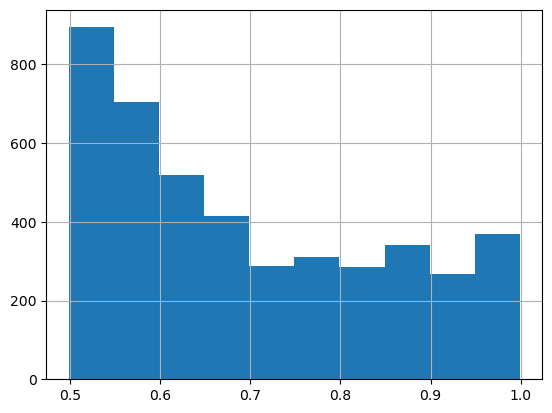

In [95]:
e_ksea['HL60'].loc[e_ksea['HL60']['tc'] == 1, 'prob'].hist()

In [93]:
e_ksea_pen = {}
for cline in clines:
    e_ksea_pen[cline] = e_ksea[cline].copy()
    prep.scale_ksea_column(e_ksea_pen[cline], 'prob', 'tc')
    # Calculate 'p_dec' and 'p_inc' columns based on conditions
    e_ksea_pen[cline]['p_dec'] = e_ksea_pen[cline].apply(lambda row: row['prob'] if row['value'] == 'dec' else 0.001, axis=1)
    e_ksea_pen[cline]['p_inc'] = e_ksea_pen[cline].apply(lambda row: row['prob'] if row['value'] == 'inc' else 0.001, axis=1)

<Axes: >

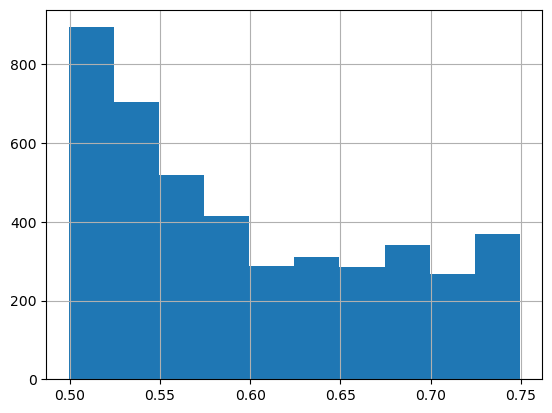

In [94]:
e_ksea_pen['HL60'].loc[e_ksea_pen['HL60']['tc'] == 1, 'prob'].hist()

In [96]:
for cline in clines:
    e_ksea_pen[cline].to_csv(f'data/processed/ebdt_data/e_ksea_penalised_{cline}.csv', index=False)

Scale fold changes to increase N of baseline values

<Axes: >

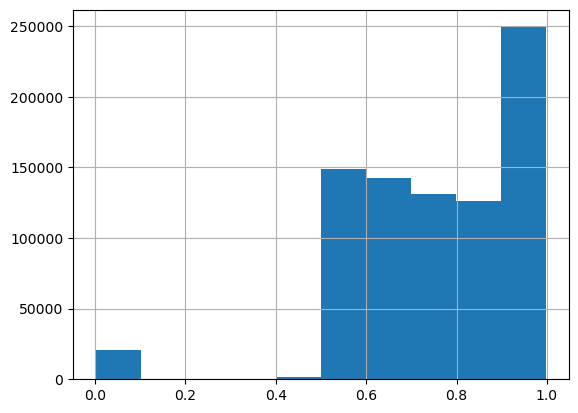

In [97]:
p_fc['HL60'].prob.hist()

In [98]:
p_fc_scaled = {}
for cline in clines:
    p_fc_scaled[cline] = p_fc[cline].copy()
    prep.scale_fc_column(p_fc_scaled[cline], 'prob')
    p_fc_scaled[cline].loc[p_fc_scaled[cline]['prob'] < 0.001, 'prob'] = 0.001
    # Calculate 'p_dec' and 'p_inc' columns based on conditions
    p_fc_scaled[cline]['p_dec'] = p_fc_scaled[cline].apply(lambda row: row['prob'] if row['value'] == 'dec' else 0.001, axis=1)
    p_fc_scaled[cline]['p_inc'] = p_fc_scaled[cline].apply(lambda row: row['prob'] if row['value'] == 'inc' else 0.001, axis=1)

<Axes: >

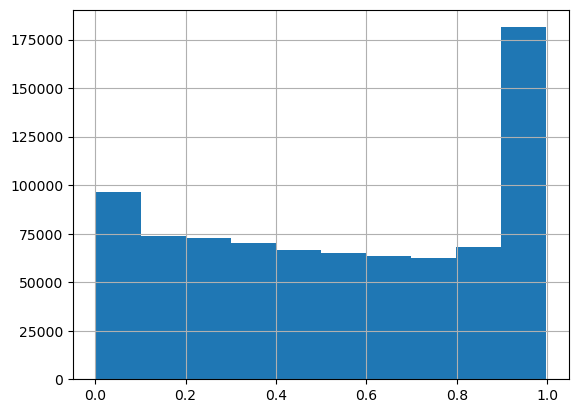

In [99]:
p_fc_scaled['HL60'].prob.hist()

In [100]:
for cline in clines:
    p_fc_scaled[cline].to_csv(f'data/processed/ebdt_data/p_fc_scaled_{cline}.csv', index=False)

Adding Cantley interactions

In [20]:
es_interaction_c = pd.read_csv('data/external/johnson_supp3_table.csv', index_col = 0)

In [21]:
# filter es_interaction to only include rows where Gene is not NaN and reset index
es_interaction_c = es_interaction_c[es_interaction_c['Gene'].notna()]
# remove rows where Gene contains ';'
es_interaction_c = es_interaction_c[~es_interaction_c['Gene'].str.contains(';')]
# merge Gene and phosphosite columns into a new column called substrate
es_interaction_c['substrate'] = es_interaction_c['Gene'] + '(' + es_interaction_c['Phosphosite'] + ')' 
# rename Gene column to tprot
es_interaction_c = es_interaction_c.rename(columns={'Gene': 'tprot'})
# find column names in es_interaction ending in _percentile using regex and save as list
percentile_cols = es_interaction_c.filter(regex='_percentile$', axis=1).columns.tolist()
# remove median_percentile column from list
percentile_cols.remove('median_percentile')
# filter es_interaction to only include substrate, tprot and percentile columns
es_interaction_c = es_interaction_c[['substrate', 'tprot'] + percentile_cols]
# stack dataframe with substrate and tprot as id_vars and percentile columns as value_vars
es_interaction_c = es_interaction_c.melt(id_vars=['substrate', 'tprot'], var_name='enzyme', value_name='percentile')
# remove _percentile from enzyme column
es_interaction_c['enzyme'] = es_interaction_c['enzyme'].str.replace('_percentile', '')
# remove tprot column
es_interaction_c.drop('tprot', axis=1, inplace=True)
es_interaction_c = es_interaction_c[['enzyme', 'substrate', 'percentile']]
es_interaction_c['percentile'] = es_interaction_c['percentile'] / 100
es_interaction_c = es_interaction_c.drop_duplicates()
es_interaction_c

,enzyme,substrate,percentile
0,AAK1,PPIAL4E(T68),0.9263
1,AAK1,GIMAP1-GIMAP5(S221),0.2991
2,AAK1,GIMAP1-GIMAP5(T215),0.8532
3,AAK1,GIMAP1-GIMAP5(T8),0.6342
4,AAK1,NBPF19(S364),0.1492
...,...,...,...
27025171,ZAK,MTRNR2L11(T3),0.6158
27025172,ZAK,PMF1-BGLAP(S11),0.2492
27025173,ZAK,PMF1-BGLAP(S196),0.3095
27025174,ZAK,PMF1-BGLAP(S6),0.6627


In [22]:
es_interaction_c = es_interaction_c[es_interaction_c['percentile'] > 0.7]
es_interaction_c

,enzyme,substrate,percentile
0,AAK1,PPIAL4E(T68),0.9263
2,AAK1,GIMAP1-GIMAP5(T215),0.8532
5,AAK1,SYNJ2BP-COX16(S21),0.9742
6,AAK1,SYNJ2BP-COX16(S40),0.8662
7,AAK1,CYP3A7-CYP3A51P(S139),0.9002
...,...,...,...
27025157,ZAK,BIVM-ERCC5(S986),0.9909
27025160,ZAK,BIVM-ERCC5(T982),0.7677
27025164,ZAK,COMMD3-BMI1(S459),0.9219
27025167,ZAK,HSPE1-MOB4(S183),0.7661


In [23]:
es_interaction_c = es_interaction_c.sort_values('percentile').drop_duplicates(['enzyme', 'substrate'], keep='last')
es_interaction_c[es_interaction_c[['enzyme', 'substrate']].duplicated()]
es_interaction_c.sort_index(inplace=True)
es_interaction_c

,enzyme,substrate,percentile
0,AAK1,PPIAL4E(T68),0.9263
2,AAK1,GIMAP1-GIMAP5(T215),0.8532
5,AAK1,SYNJ2BP-COX16(S21),0.9742
6,AAK1,SYNJ2BP-COX16(S40),0.8662
7,AAK1,CYP3A7-CYP3A51P(S139),0.9002
...,...,...,...
27025157,ZAK,BIVM-ERCC5(S986),0.9909
27025160,ZAK,BIVM-ERCC5(T982),0.7677
27025164,ZAK,COMMD3-BMI1(S459),0.9219
27025167,ZAK,HSPE1-MOB4(S183),0.7661


In [25]:
es_interaction_c.to_csv('data/processed/ebdt_data/es_interaction_cantley.csv', index=False)

Adding Cantley KSEA

In [15]:
e_ksea_c = pd.read_csv('data/external/ksea_HL60_mp_cantley.csv')

In [16]:
e_ksea_c

,kpa,pert,p_val,n_sub_data,mlog2fc,z_score,n_sub_db,status
0,AAK1,AC220,0.143878,16,-0.265765,-1.063059,19,unaffected
1,AAK1,AT13148,0.141299,16,-0.268625,-1.074500,19,unaffected
2,AAK1,AZ20,0.083940,16,-0.344761,-1.379046,19,unaffected
3,AAK1,AZD1480,0.466947,16,0.020737,0.082947,19,unaffected
4,AAK1,AZD3759,0.490680,16,0.005841,0.023365,19,unaffected
...,...,...,...,...,...,...,...,...
28909,ZAK,Torin,0.048087,42,-0.256713,-1.663692,42,unaffected
28910,ZAK,Trametinib,0.304211,42,-0.079054,-0.512327,42,unaffected
28911,ZAK,U73122,0.393330,42,0.041762,0.270650,42,unaffected
28912,ZAK,Ulixertinib,0.205627,42,-0.126789,-0.821688,42,unaffected


In [17]:
# Create a function to determine 'inc' or 'dec' randomly when fc is 0
def random_inc_dec(row, val):
    if row[val] == 0:
        return random.choice(['inc', 'dec'])
    else:
        return 'inc' if row[val] > 0 else 'dec'
    
# Add 'value' column based on zscore
e_ksea_c['value'] = e_ksea_c.apply(lambda row: random_inc_dec(row, 'z_score'), axis=1)

# Calculate 'prob' column
e_ksea_c['prob'] = 1 - e_ksea_c['p_val'] - 0.001

# Calculate 'p_dec' and 'p_inc' columns based on conditions
e_ksea_c['p_dec'] = e_ksea_c.apply(lambda row: row['prob'] if row['value'] == 'dec' else 0.001, axis=1)
e_ksea_c['p_inc'] = e_ksea_c.apply(lambda row: row['prob'] if row['value'] == 'inc' else 0.001, axis=1)

# Reorder and rename columns
e_ksea_c = e_ksea_c[['kpa', 'pert', 'n_sub_data', 'value', 'prob', 'p_dec', 'p_inc']]
e_ksea_c.columns = ['enzyme', 'sample', 'tc', 'value', 'prob', 'p_dec', 'p_inc']

e_ksea_c

,enzyme,sample,tc,value,prob,p_dec,p_inc
0,AAK1,AC220,16,dec,0.855122,0.855122,0.001000
1,AAK1,AT13148,16,dec,0.857701,0.857701,0.001000
2,AAK1,AZ20,16,dec,0.915060,0.915060,0.001000
3,AAK1,AZD1480,16,inc,0.532053,0.001000,0.532053
4,AAK1,AZD3759,16,inc,0.508320,0.001000,0.508320
...,...,...,...,...,...,...,...
28909,ZAK,Torin,42,dec,0.950913,0.950913,0.001000
28910,ZAK,Trametinib,42,dec,0.694789,0.694789,0.001000
28911,ZAK,U73122,42,inc,0.605670,0.001000,0.605670
28912,ZAK,Ulixertinib,42,dec,0.793373,0.793373,0.001000


In [18]:
e_ksea_c.to_csv('data/processed/ebdt_data/e_ksea_c_HL60.csv', index=False)

In [19]:
e_ksea_c_pen = e_ksea_c.copy()
prep.scale_ksea_column(e_ksea_c_pen, 'prob', 'tc')
e_ksea_c_pen.loc[e_ksea_c_pen['tc'] == 1]

,enzyme,sample,tc,value,prob,p_dec,p_inc
122,ACP1,AC220,1,dec,0.749408,0.998815,0.001000
123,ACP1,AT13148,1,inc,0.503603,0.001000,0.507207
124,ACP1,AZ20,1,dec,0.591384,0.682768,0.001000
125,ACP1,AZD1480,1,inc,0.598543,0.001000,0.697087
126,ACP1,AZD3759,1,inc,0.652651,0.001000,0.805303
...,...,...,...,...,...,...,...
28482,WNK2,Torin,1,inc,0.742864,0.001000,0.985728
28483,WNK2,Trametinib,1,inc,0.580108,0.001000,0.660217
28484,WNK2,U73122,1,dec,0.586322,0.672643,0.001000
28485,WNK2,Ulixertinib,1,inc,0.652308,0.001000,0.804617


<Axes: >

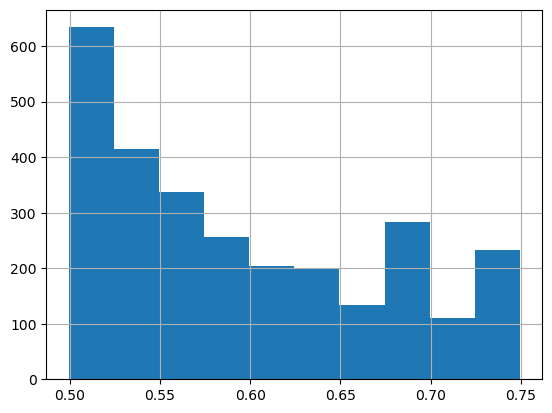

In [20]:
e_ksea_c_pen.loc[e_ksea_c_pen['tc'] == 1, 'prob'].hist()

In [22]:
# Calculate 'p_dec' and 'p_inc' columns based on conditions
e_ksea_c_pen['p_dec'] = e_ksea_c_pen.apply(lambda row: row['prob'] if row['value'] == 'dec' else 0.001, axis=1)
e_ksea_c_pen['p_inc'] = e_ksea_c_pen.apply(lambda row: row['prob'] if row['value'] == 'inc' else 0.001, axis=1)
e_ksea_c_pen.loc[e_ksea_c_pen['tc'] == 1]

,enzyme,sample,tc,value,prob,p_dec,p_inc
122,ACP1,AC220,1,dec,0.749408,0.749408,0.001000
123,ACP1,AT13148,1,inc,0.503603,0.001000,0.503603
124,ACP1,AZ20,1,dec,0.591384,0.591384,0.001000
125,ACP1,AZD1480,1,inc,0.598543,0.001000,0.598543
126,ACP1,AZD3759,1,inc,0.652651,0.001000,0.652651
...,...,...,...,...,...,...,...
28482,WNK2,Torin,1,inc,0.742864,0.001000,0.742864
28483,WNK2,Trametinib,1,inc,0.580108,0.001000,0.580108
28484,WNK2,U73122,1,dec,0.586322,0.586322,0.001000
28485,WNK2,Ulixertinib,1,inc,0.652308,0.001000,0.652308


In [23]:
e_ksea_c_pen

,enzyme,sample,tc,value,prob,p_dec,p_inc
0,AAK1,AC220,16,dec,0.855122,0.855122,0.001000
1,AAK1,AT13148,16,dec,0.857701,0.857701,0.001000
2,AAK1,AZ20,16,dec,0.915060,0.915060,0.001000
3,AAK1,AZD1480,16,inc,0.532053,0.001000,0.532053
4,AAK1,AZD3759,16,inc,0.508320,0.001000,0.508320
...,...,...,...,...,...,...,...
28909,ZAK,Torin,42,dec,0.950913,0.950913,0.001000
28910,ZAK,Trametinib,42,dec,0.694789,0.694789,0.001000
28911,ZAK,U73122,42,inc,0.605670,0.001000,0.605670
28912,ZAK,Ulixertinib,42,dec,0.793373,0.793373,0.001000


In [24]:
e_ksea_c_pen.to_csv('data/processed/ebdt_data/e_ksea_c_penalised_HL60.csv', index=False)

Adding 'true positive' phosphosites

In [ ]:
ser = pd.read_csv('data/external/pr2c00131_si_005_Ser_data.csv', index_col = False)
thr = pd.read_csv('data/external/pr2c00131_si_005_Thr_data.csv', index_col = False)
tyr = pd.read_csv('data/external/pr2c00131_si_005_Tyr_data.csv', index_col = False)

In [ ]:
phosphosites = pd.DataFrame(columns=['phosphosite', 'Phosphorylation likelihood in PSP', 'Phosphorylation likelihood in PA'])
for residue_df in [ser, thr, tyr]:
    residue_df = residue_df.loc[residue_df['Phosphorylation likelihood in PSP'] != '-']
    residue_df = residue_df.loc[residue_df['Phosphorylation likelihood in PA'] != '-']
    residue_df = residue_df.loc[residue_df['Phosphorylation likelihood in PA'] != 'Not phosphorylated']
    # map UniProtKB_AC-ID to Gene_Name
    id_list = residue_df['Protein'].unique().tolist()
    mapping = prep.id_mapping_to_dataframe(id_list, from_db="UniProtKB_AC-ID", to_db="Gene_Name")
    # use mapping to replace Protein column with Gene_Name
    residue_df = residue_df.merge(mapping, left_on='Protein', right_on='UniProtKB_AC-ID', how='left')
    # merge Gene and phosphosite columns into a new column called substrate
    residue_df['phosphosite'] = residue_df['Gene_Name'] + '(' + residue_df['Site'] + residue_df['Position in target protein'].astype(str) + ')' 
    residue_df = residue_df[['phosphosite', 'Phosphorylation likelihood in PSP', 'Phosphorylation likelihood in PA']].drop_duplicates()
    phosphosites = pd.concat([phosphosites, residue_df], ignore_index=True).reset_index(drop=True)

In [72]:
phosphosites.to_csv('data/processed/ebdt_data/phosphosites_tp.csv', index=False)

In [11]:
phosphosites = pd.read_csv('data/processed/ebdt_data/phosphosites_tp.csv')
phosphosites

,phosphosite,Phosphorylation likelihood in PSP,Phosphorylation likelihood in PA
0,NBPF19(S1096),Low,Low
1,NBPF19(S2560),Low,Low
2,PPIAL4C(S95),Low,Other
3,PPIAL4C(S99),Low,Other
4,PPIAL4C(S110),Medium,Other
...,...,...,...
100036,FAM169A(Y281),Low,Other
100037,FAM169A(Y289),Low,Other
100038,IVNS1ABP(Y356),Low,Other
100039,SEC23IP(Y637),Low,Other


In [13]:
pst_tp = phosphosites['phosphosite'].unique().tolist()
pst_tp

['NBPF19(S1096)',
 'NBPF19(S2560)',
 'PPIAL4C(S95)',
 'PPIAL4C(S99)',
 'PPIAL4C(S110)',
 'KANSL1L(S526)',
 'KANSL1L(S714)',
 'SLC12A8(S662)',
 'SLC12A8(S665)',
 'RBM47(S540)',
 'E2F8(S52)',
 'E2F8(S68)',
 'E2F8(S71)',
 'E2F8(S102)',
 'E2F8(S351)',
 'E2F8(S355)',
 'E2F8(S357)',
 'E2F8(S358)',
 'E2F8(S396)',
 'E2F8(S413)',
 'E2F8(S416)',
 'E2F8(S417)',
 'E2F8(S664)',
 'E2F8(S767)',
 'UBA6(S16)',
 'UBA6(S36)',
 'UBA6(S737)',
 'UBA6(S743)',
 'UBA6(S951)',
 'ESYT2(S676)',
 'ESYT2(S685)',
 'ESYT2(S688)',
 'ESYT2(S691)',
 'ESYT2(S693)',
 'ESYT2(S699)',
 'ESYT2(S704)',
 'ESYT2(S711)',
 'ESYT2(S736)',
 'ESYT2(S737)',
 'ESYT2(S738)',
 'ESYT2(S739)',
 'ESYT2(S743)',
 'ESYT2(S748)',
 'ESYT2(S755)',
 'ESYT2(S758)',
 'ESYT2(S761)',
 'ESYT3(S697)',
 'MED19(S194)',
 'MED19(S196)',
 'MED19(S226)',
 'MED19(S234)',
 'MED19(S235)',
 'BLTP3B(S414)',
 'BLTP3B(S418)',
 'BLTP3B(S423)',
 'BLTP3B(S443)',
 'BLTP3B(S446)',
 'BLTP3B(S449)',
 'BLTP3B(S754)',
 'BLTP3B(S774)',
 'BLTP3B(S889)',
 'BLTP3B(S891)',
 'BLTP

In [103]:
# Filter all the data based on the phosphosites in pst_tp
p_fc_tp = {}
for cline in clines:
    p_fc_tp[cline] = p_fc[cline][p_fc[cline]['phosphosite'].isin(pst_tp)]
p_fc_tp

{'HL60':           phosphosite       sample value      prob     p_dec     p_inc
 0          AAAS(S495)      AZD5438   dec  0.611448  0.611448  0.001000
 1         AAGAB(S310)      AZD5438   inc  0.506631  0.001000  0.506631
 2         AAGAB(S311)      AZD5438   inc  0.778478  0.001000  0.778478
 3           AAK1(S14)      AZD5438   dec  0.682618  0.682618  0.001000
 4           AAK1(S21)      AZD5438   dec  0.698036  0.698036  0.001000
 ...               ...          ...   ...       ...       ...       ...
 821055  ZNF462(S1451)  Vemurafenib   inc  0.001000  0.001000  0.001000
 821056   ZNF521(S605)  Vemurafenib   dec  0.001000  0.001000  0.001000
 821057   ZNF697(S123)  Vemurafenib   inc  0.001000  0.001000  0.001000
 821058   ZNF777(S351)  Vemurafenib   dec  0.001000  0.001000  0.001000
 821059  ZSCAN10(S107)  Vemurafenib   inc  0.001000  0.001000  0.001000
 
 [667645 rows x 6 columns],
 'MCF7':           phosphosite       sample value      prob     p_dec     p_inc
 0          AAAS(S

In [104]:
print(len(p_fc['HL60']['phosphosite'].unique().tolist()))
print(len(p_fc_tp['HL60']['phosphosite'].unique().tolist()))

13460
10945


In [105]:
p_fc_scaled_tp = {}
for cline in clines:
    p_fc_scaled_tp[cline] = p_fc_scaled[cline][p_fc_scaled[cline]['phosphosite'].isin(pst_tp)]
p_fc_scaled_tp

{'HL60':           phosphosite       sample value      prob     p_dec     p_inc
 0          AAAS(S495)      AZD5438   dec  0.225223  0.225223  0.001000
 1         AAGAB(S310)      AZD5438   inc  0.016216  0.001000  0.016216
 2         AAGAB(S311)      AZD5438   inc  0.558283  0.001000  0.558283
 3           AAK1(S14)      AZD5438   dec  0.367137  0.367137  0.001000
 4           AAK1(S21)      AZD5438   dec  0.397880  0.397880  0.001000
 ...               ...          ...   ...       ...       ...       ...
 821055  ZNF462(S1451)  Vemurafenib   inc  0.001000  0.001000  0.001000
 821056   ZNF521(S605)  Vemurafenib   dec  0.001000  0.001000  0.001000
 821057   ZNF697(S123)  Vemurafenib   inc  0.001000  0.001000  0.001000
 821058   ZNF777(S351)  Vemurafenib   dec  0.001000  0.001000  0.001000
 821059  ZSCAN10(S107)  Vemurafenib   inc  0.001000  0.001000  0.001000
 
 [667645 rows x 6 columns],
 'MCF7':           phosphosite       sample value      prob     p_dec     p_inc
 0          AAAS(S

In [107]:
es_interaction_tp = es_interaction[es_interaction['substrate'].isin(pst_tp)]
es_interaction_tp

,enzyme,substrate
4,ABL1,ABI1(Y213)
5,ABL1,ABL1(S919)
7,ABL1,ABL1(Y226)
9,ABL1,ABL1(Y393)
14,ABL1,AHSA1(Y223)
...,...,...
20510,ZAP70,ZAP70(Y292)
20511,ZAP70,ZAP70(Y315)
20512,ZAP70,ZAP70(Y319)
20513,ZAP70,ZAP70(Y492)


In [31]:
es_interaction_c_tp = es_interaction_c[es_interaction_c['substrate'].isin(pst_tp)]
es_interaction_c_tp

,enzyme,substrate,percentile
135,AAK1,ATP6AP2(S24),0.7536
153,AAK1,SLC12A8(S665),0.7211
154,AAK1,RBM47(T519),0.8166
157,AAK1,E2F8(S102),0.9501
158,AAK1,E2F8(S351),0.7668
...,...,...,...
27025088,ZAK,MORC2(S739),0.8829
27025093,ZAK,MORC2(S785),0.8545
27025109,ZAK,IVNS1ABP(S336),0.8050
27025114,ZAK,SEC23IP(S136),0.9115


In [14]:
p_regulates_tp = p_regulates[p_regulates['phosphosite'].isin(pst_tp)]

In [108]:
# save es_interaction, e_function, e_ksea, p_fc, e_activity and p_occupancy to csv
es_interaction_tp.to_csv('data/processed/ebdt_data/es_interaction_tp.csv', index=False)
es_interaction_c_tp.to_csv('data/processed/ebdt_data/es_interaction_cantley_tp.csv', index=False)
p_regulates_tp.to_csv('data/processed/ebdt_data/p_regulates_tp.csv', index=False)
for cline in clines:
    p_fc_tp[cline].to_csv(f'data/processed/ebdt_data/p_fc_{cline}_tp.csv', index=False)
    p_fc_scaled_tp[cline].to_csv(f'data/processed/ebdt_data/p_fc_scaled_{cline}_tp.csv', index=False)

DK interactions

In [6]:
dk_interaction = pd.read_csv('data/external/pert_kin_rel.csv')

In [8]:
dk_interaction = dk_interaction[['perturbagen', 'kinase']]
dk_interaction.columns = ['drug', 'enzyme']

In [10]:
dk_interaction.to_csv('data/processed/ebdt_data/dk_interaction.csv', index=False)